In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from itertools import product

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

yearly_temp = calc_temps('2016-08-23', '2017-08-23')
yearly_temp

[(58.0, 74.59058295964125, 87.0)]

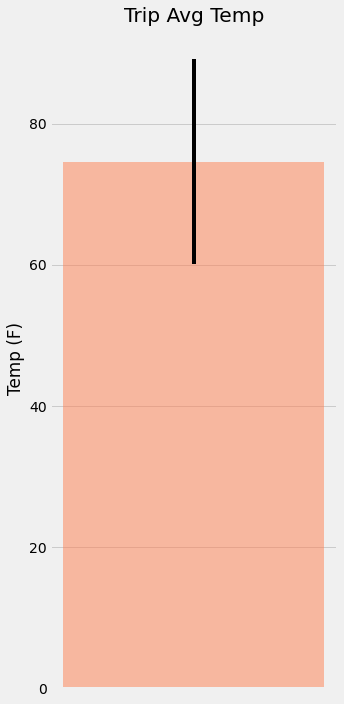

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmax = yearly_temp[0][2]
tmin = yearly_temp[0][0]
peak_to_peak = tmax - tmin # This will be our error line
tavg = yearly_temp[0][1] # This will be the height of our graph 

# Plot
fig, ax = plt.subplots(figsize = (5, 10)) # Create figure & axis objects 
ax.bar(x = 1, height = tavg, yerr = peak_to_peak/2, width = 0.4,color = 'coral', alpha = 0.5) # Plotting
ax.set_xticks([0]) 
plt.yticks(size=14)

# "Labels"
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.savefig("Images/Trip_Avg_Temp.png", bbox_inches = 'tight')
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_station = pd.read_sql("SELECT s.station,s.name,s.latitude,s.longitude,s.elevation,sum(m.prcp) as 'Total Rainfall'\
                            FROM station s\
                            JOIN measurement m ON(s.station = m.station)\
                            WHERE m.date BETWEEN '2017-02-22' AND '2017-03-01'\
                            GROUP BY s.station\
                            ORDER BY SUM(m.prcp) DESC" , conn)
rain_station.head(10)

,station,name,latitude,longitude,elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.02
1,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.57
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.42
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.22
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.29
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.27
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.72


### Daily Temperature Normals

In [27]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2018, 1, 7)

# Use the start and end date to create a range of dates
datelist = pd.date_range(start_date, periods=7).tolist()

# Stip off the year and save a list of %m-%d strings
dates = []
for date in datelist:
    dates.append(dt.datetime.strftime(date, '%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dates:
    normals.append(daily_normals(date))

print("Chosen Dates: Aug 23 to Aug 29 (7 day trip)")
for normal in normals:
    print(normal)

Chosen Dates: Aug 23 to Aug 29 (7 day trip)
[(62.0, 69.15384615384616, 77.0)]
[(60.0, 69.39622641509433, 77.0)]
[(62.0, 68.9090909090909, 77.0)]
[(58.0, 70.0, 76.0)]
[(56.0, 67.96428571428571, 76.0)]
[(61.0, 68.96491228070175, 76.0)]
[(57.0, 68.54385964912281, 76.0)]


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_list = []
for normal in normals:
    normal_list.append(np.ravel(normal))
trip_normals_df = pd.DataFrame(normal_list, columns = ['tmin', 'tavg', 'tmax'])
trip_normals_df.index = [str(date.strftime('%Y-%m-%d')) for date in datelist]
trip_normals_df

,tmin,tavg,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


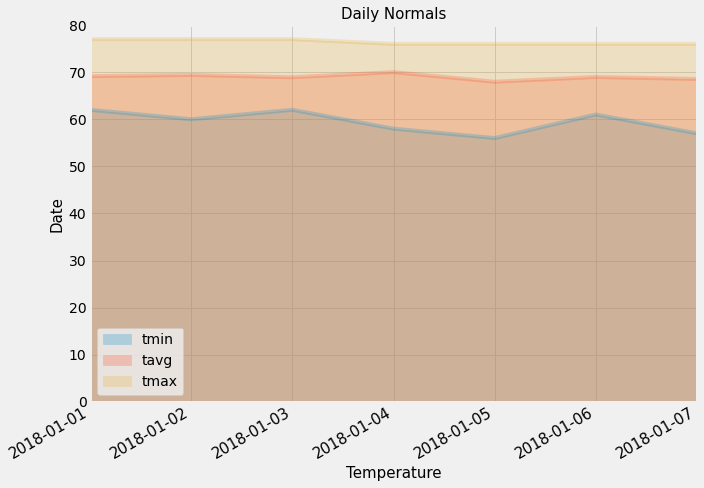

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,7))
trip_normals_df.plot(kind='area', stacked=False, alpha=0.25, ax=ax)
plt.title("Daily Normals",fontsize=15)
plt.ylabel("Date",fontsize=15)
plt.xlabel("Temperature",fontsize=15)

plt.ylim(0,80)
plt.xlim(0,4)
plt.yticks(size=14)
plt.xticks(np.arange(7), trip_normals_df.index,fontsize=15)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha="right" )

plt.savefig("Images/daily_normals.png", bbox_inches = 'tight')
plt.tight_layout()
plt.show()

## Close Session

In [77]:
# Close Session
session.close()